# init

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import numpy as np
from rasterio.transform import from_origin
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as eps

In [2]:
# slope function 
def slope(array):
    x, y = np.gradient(array)
    #APS: I am really not sure why this is here, need to check the math
    #slope in percent
    #slope_pct = np.sqrt(x*x + y*y)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    return slope

# input

In [20]:
#input a raster file
raster_path = Path("D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\")
#raster_path = Path('/Users/X/Library/CloudStorage/Dropbox/x/PostDoc/23 10 LMU/13 exp_cases/24 01 Urban SSP MAN MUM JAK/GIS_temp')
raster_file = 'JAK_DEM_elevation_TanDEM_X_30m.tif'
in_raster = rasterio.open(raster_path/raster_file)

AOI_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
AOI_file = 'JAK_LIM_BoundingBox_AOI_A.shp'

AOI_gdf = gpd.read_file(AOI_path/AOI_file)
print('AOI:', AOI_gdf.crs.to_epsg(),'Raster:', in_raster.crs)

AOI: 32748 Raster: EPSG:32748


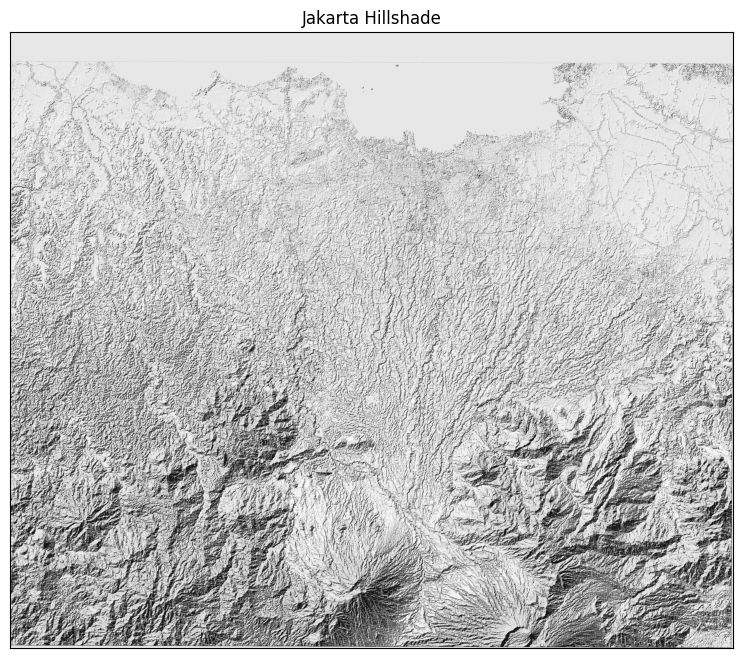

In [21]:
# calculate hillshade with earthpy
dem = in_raster.read(1)

#with help from [Charlotta Mirbach](https://gitlab.lrz.de/00000000013642E5)
hillshade = es.hillshade(dem, azimuth=315, altitude=45)
eps.plot_bands(
    hillshade,
    cbar=False,
    title="Jakarta Hillshade",
    figsize=(10, 8)
)

plt.show()

In [32]:
# export hillshade

#setting up the output file
out_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
out_file = 'JAK_DEM_hillshade_TanDEM_X_30m.tif'
out_url = out_path/out_file

AOI_geom = AOI_gdf.geometry
clipped_array, clipped_transform = mask(dataset=hillshade, shapes=AOI_geom, crop=True, nodata=0, all_touched=True, invert=False) #, pad=False, pad_width=0.5

out_meta = in_raster.meta.copy()
out_meta.update({"driver": "GTiff",
                 'dtype': rasterio.float32,
                 "height": clipped_array.shape[1],
                 "width": clipped_array.shape[2],
                 "transform": clipped_transform,
                 "nodata": 0})  

with rasterio.open(out_url, "w", **out_meta) as dest:
    dest.write(hillshade)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

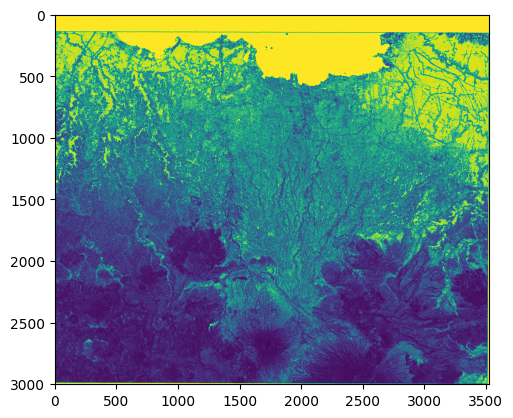

<Axes: >

In [8]:
#calculate slope with earthpy

slope_raster = slope(in_raster.read(1))

#exporting the raster
out_path = raster_path
out_file = 'JAK_DEM_slope_TanDEM_X_30m.tif'
out_url = out_path/out_file
with rasterio.open(out_url, "w", driver='GTiff',
                    height = in_raster.shape[0], width=in_raster.shape[1],
                    count=1, dtype=list(in_raster.dtypes)[0],
                    crs=in_raster.crs, transform = in_raster.transform) as dest:
        dest.write(slope_raster, indexes=1)
show(slope_raster)